# Introduction to jax.shard

`jax 0.4` newly released the shard feature, which is super easy to use: maybe you can just use the `jax.Array` as usual, but it will **automatically** be computed on multiple devices!

## A recap of jax: upgraded version of numpy

Here let's just play with some `jax.numpy`, you'll find that it's (almost) nothing different from the numpy, but cross-platform, and have grad.

In [1]:
#let's install the newest version of jax
!pip install "jax[cpu]" --upgrade -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html


I'm runing the notebook on metis, with code:
```bash
qsub -I -lselect=1:ncpus=8:ngpus=0:mem=80gb
```
to allocate 8 CPU cores, pretending I have 8 different devices. (I cannot allocate 8 GPUs, or Yi might be mad)

In [1]:
import os
#this is to separate CPU cores into 8 different devices. 
#Otherwise clever jax will auto-detect all the CPU cores as one device.
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import astropy
print('We have '+str(jax.device_count())+' devices')
jax.version.__version__

2023-06-20 16:41:14.247708: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


We have 8 devices


'0.4.10'

### Example: linear regression with gradient descent
let's use the most simplest model -- the linear regression model as an example, to see how `jax.numpy` is actually the same as numpy.

our model was like:
$$
y = \sqrt{2}x + 0.6 + \epsilon \\
ϵ \sim \mathcal{N}(0,0.3)
$$

So let's first generate `x` and `y`

In [2]:
# unlike numpy, here jax need a random key for each random sampling function
x = jax.random.uniform(jax.random.PRNGKey(0), [8192])
eps = jax.random.normal(jax.random.PRNGKey(1), [8192])*0.3
y = jnp.sqrt(2)*x+eps+0.6

Next we imagine: we only know x, y, and the distribution of error term $\epsilon$, try to infer the value of linear parameters. As a demostration, we will only use the MLE method to optimise.

#### Construct likelihood

First we construct our model `y_model = kx + b`

In [3]:
def linear_model(params):
    y_model = params['k']*x + params['b']
    return y_model

Next is the likelihood $$\log\mathcal{L} = - \frac{(y_{model}-y_{obs})^2}{2\sigma^2} - 0.28 $$

In [4]:
def log_p(params):
    y_model = linear_model(params)
    log_l = -(y_model - y)**2/(2*0.09)
    return log_l.sum()

#### Run the MLE
Now we can run the code to get the likelihood.

In [5]:
# first we initialize a k and b
params = {'k':1.,'b':1.}

# then we calculate the log_l
%time log_l = log_p(params)

log_l

CPU times: user 57.5 ms, sys: 2.89 ms, total: 60.4 ms
Wall time: 60 ms


Array(-6385.2905, dtype=float32)

How do we get the **gradient**? Just one function: `jax.value_and_grad()`

In [6]:
grad_log_p = jax.value_and_grad(log_p)
log_l_value,log_l_grad = grad_log_p(params)

In [7]:
#we can see we have the same value as before
log_l_value

Array(-6385.2905, dtype=float32)

In [8]:
#and the grad?
log_l_grad

{'b': Array(-17343.719, dtype=float32, weak_type=True),
 'k': Array(-5533.046, dtype=float32, weak_type=True)}

Cool! now we can maximize the `log_l`, just design a loop like this:

In [9]:
#we first define a function to update dict:
@jax.jit
def gradient_descent(params,grads,lr=1e-5):
    for keys in params.keys():
        params[keys] = params[keys] + grads[keys]*lr
    return params

In [10]:
%%time
log_l_iter = []
iters = 1000
for i in range(iters):
    log_l_value,log_l_grad = grad_log_p(params)
    log_l_iter.append(log_l_value)
    params = gradient_descent(params,log_l_grad)

CPU times: user 5.24 s, sys: 0 ns, total: 5.24 s
Wall time: 5.27 s


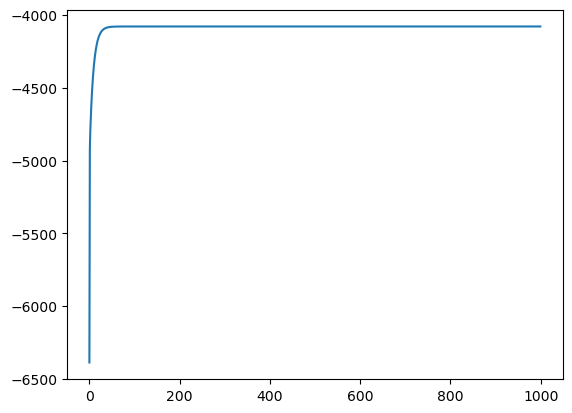

In [11]:
plt.plot(log_l_iter)

In [60]:
params

{'b': Array(0.6016596, dtype=float32, weak_type=True),
 'k': Array(1.415271, dtype=float32, weak_type=True)}

## Simple parallelism with `vmap`

Some times we have GPU, which is optimised for parallel computation. JAX provides multiple functions to do the parallel computing, let's start from the simplest: `vmap`.

The `vmap` serves for vectorization. let's take a look at the loop:
```python
for i in range(n):
    c[i] = a[i] + b[i]
```
In principle the processor just carry out the loop one by one from 1 to n. Fortunately, modern CPUs can process 4 to 8 `add` ops at the same time, and GPUs can even do more, like thousands. So it would be a waste to do the loop one by one. The so-called vectorization is, for example, not feed `a[i]` and `b[i]` to CPU, but a vector of `a[i],a[i+1],a[i+2],a[i+3]` and `b[i],b[i+1],b[i+2],b[i+3]` to CPU.

Many jax functions has built-in vectorization, if you write `c = a + b` then it's automatically vectorized. However if you have your own function, sometimes it's hard to write a vectorized version. You can write your function like:
```python
def f(a,b):
    return a+b
for i in range(n):
    c[i] = f(a[i],b[i])
```
Then use `vmap` to convert the `f` to a vectorized version.


### Example: convolution

The convolution process is a bit complicated, and is hard to be vectorized manually. Here the math eqn is:
$$
y_i = \sum_{j = 0,1,2}x_{i+j}*w_j 
$$

In [98]:
#suppose here w is a 1d vector of length 3
@jax.jit
def convolve(x,w):
    y = jnp.concatenate([x,jnp.zeros([w.shape[0]-1])],axis = 0)
    for i in range(len(x)):
        x = x.at[i].set(jnp.sum(y[i:i+3]+w))
    return x

In [99]:
x = jnp.arange(5,dtype = jnp.float32)
w = jnp.array([2., 3., 4.])
convolve(x,w)

Array([12., 15., 18., 16., 13.], dtype=float32)

Now everything looks good, but what if our x have a shape of `[8192,5]`?

In [100]:
x = jax.random.uniform(jax.random.PRNGKey(0), [8192,128])

In [101]:
%%time
result = []
for i in range(x.shape[0]):
    result.append(convolve(x[i],w))

CPU times: user 6.56 s, sys: 2.67 ms, total: 6.56 s
Wall time: 6.58 s


We transfer to vmap

In [102]:
convolve_batch = jax.vmap(lambda x: convolve(x,w))
%time result_vmap = convolve_batch(x)

CPU times: user 1.64 s, sys: 40.2 ms, total: 1.68 s
Wall time: 1.66 s


Now have you seen the power of vmap?
**100x** speed up!

## Automatic parallel with shard

Now we've finally come to the most exciting part: The sharding part. This module allows people put data on different devices, thus, one can utilize multiple devices to do the same job. This is not anything new -- but it's super easy to use.

As we said before, the meaning of shard is to put the different part of an array on different devices, so that when we do the computing, the different devices will compute different parts of the array. Take an analogy: if you want cook 8 chicken wing at the same time, and you have 8 pots and 8 people, of course you can put one chicken wing on one pot, and cook at the same time.

For example let's get back to this simplest `c = a + b`

In [2]:
a = jax.random.uniform(jax.random.PRNGKey(0), [8192])
b = jax.random.uniform(jax.random.PRNGKey(0), [8192])

In [3]:
%%time 
c = a + b

CPU times: user 9.67 ms, sys: 1.71 ms, total: 11.4 ms
Wall time: 10.7 ms


Now let's put `a` and `b` on different devices.

First let's create a `sharding` object, it's like telling people the way you split the chicken wings.

In [4]:
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

# Create a Sharding object to distribute a value across devices:
sharding = PositionalSharding(mesh_utils.create_device_mesh((8,)))

a_shard = jax.device_put(a, sharding)
b_shard = jax.device_put(b, sharding)

In [5]:
jax.debug.visualize_array_sharding(a_shard)

  CPU 0    CPU 1    CPU 2    CPU 3    CPU 4    CPU 5    CPU 6    CPU 7  
                                                                        

In [6]:
%%time 
c = a + b

CPU times: user 45 µs, sys: 33 µs, total: 78 µs
Wall time: 86.8 µs


### Example: Simple neural network

Here we will use photo-z as an example to demonstrate how we use distributed calculation to speed up the training.

#### Data
First we just open the dataset (provided by @Zechang Sun)

In [7]:
from astropy.io import fits
import numpy as np
data = fits.open('/work/dkn16/Intro_JAX_sharding/pdr3_specz_photometry.fits')

In [8]:
#output is the redshift 
spec_z = data[1].data['specz_redshift'].astype(np.float32)

#input is the magnitude in 5 bands
y_flux = data[1].data['y_cmodel_flux'].astype(np.float32).reshape((-1,1))
g_flux = data[1].data['g_cmodel_flux'].astype(np.float32).reshape((-1,1))
r_flux = data[1].data['r_cmodel_flux'].astype(np.float32).reshape((-1,1))
i_flux = data[1].data['i_cmodel_flux'].astype(np.float32).reshape((-1,1))
z_flux = data[1].data['z_cmodel_flux'].astype(np.float32).reshape((-1,1))

input_data = np.concatenate([y_flux,g_flux,r_flux,i_flux,z_flux],axis = 1)
data.close()

In [9]:
input_data[np.isnan(input_data)] = 0.
input_data[input_data<0] = 0.
#np.min(input_data,axis=0)

In [10]:
input_data = np.log10(input_data + 1.)

(array([2.4423e+04, 6.3004e+04, 5.8131e+04, 4.7391e+04, 4.6381e+04,
        3.7633e+04, 4.7642e+04, 6.0209e+04, 5.5749e+04, 4.7084e+04,
        4.3110e+04, 3.8222e+04, 3.2617e+04, 2.2679e+04, 1.6371e+04,
        1.1934e+04, 1.0160e+04, 6.3580e+03, 5.7810e+03, 5.2600e+03,
        4.8920e+03, 4.6250e+03, 4.3500e+03, 4.7750e+03, 4.1410e+03,
        3.4140e+03, 3.0080e+03, 2.8340e+03, 2.5210e+03, 2.3540e+03,
        2.6470e+03, 2.9160e+03, 2.8510e+03, 2.5640e+03, 2.4860e+03,
        2.1780e+03, 2.0180e+03, 1.8650e+03, 1.5140e+03, 1.3020e+03,
        1.2410e+03, 1.1830e+03, 1.0750e+03, 9.9000e+02, 9.6600e+02,
        9.0100e+02, 7.1700e+02, 6.6400e+02, 5.6000e+02, 4.8600e+02,
        4.2900e+02, 3.8300e+02, 3.1500e+02, 2.7600e+02, 2.3200e+02,
        2.0700e+02, 2.2300e+02, 1.7100e+02, 1.4800e+02, 1.4000e+02,
        1.0600e+02, 1.0500e+02, 1.0500e+02, 1.1500e+02, 1.2100e+02,
        9.7000e+01, 9.1000e+01, 8.8000e+01, 7.1000e+01, 5.4000e+01,
        5.6000e+01, 3.9000e+01, 2.2000e+01, 1.90

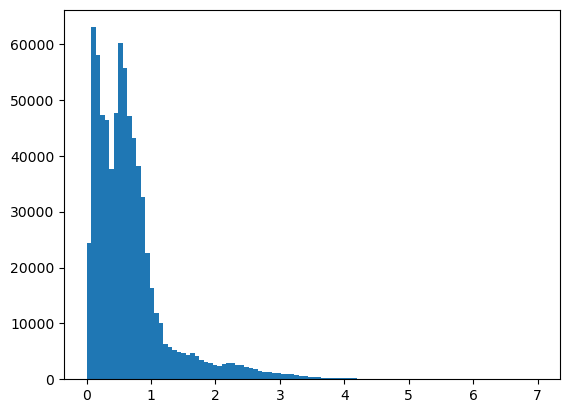

In [11]:
#This is to check if we normalize our model properly
plt.hist(spec_z,100)

#### Model

Let's use a super simple 3-layer NN: one input layer, one output layer and one hidden layer.
$$
y_1 = {\rm Relu}(W_1 \cdot x + b1) \\
y_2 = {\rm Relu}(W_2 \cdot y_1 + b2)\\
y_3 = W_3 \cdot y_2\\
$$
Our activation function is `ReLU`. Unfortunately their is no built-in `ReLU` in JAX, but you can use other package like `Haiku` for NN and `Optax` for optimising.

In [12]:
#This is our model
@jax.jit
def predict(params, inputs):
    y1 = jnp.dot(inputs, params['w1']) + params['b1']
    y1 = jnp.maximum(y1, 0)
    y2 = jnp.dot(y1, params['w2']) + params['b2']
    y2 = jnp.maximum(y2, 0)
    y3 = jnp.dot(y2, params['w3'])
    return y3

@jax.jit
def loss(params, batch):
    inputs, targets = batch
    predictions = predict(params, inputs)
    return jnp.mean((predictions - targets)**2)

In [66]:
#Here we initialize the model parameters

w1 = jax.random.normal(jax.random.PRNGKey(0),[5,64])
b1 = jax.random.normal(jax.random.PRNGKey(1),[64])
w2 = jax.random.normal(jax.random.PRNGKey(2),[64,64])
b2 = jax.random.normal(jax.random.PRNGKey(3),[64])
w3 = jax.random.normal(jax.random.PRNGKey(8),[64,1])

params = {'w1':w1,'w2':w2,'w3':w3,'b1':b1,'b2':b2}

In [67]:
loss_grad = jax.value_and_grad(loss)
%time loss_grad(params,(input_data[0:2048],spec_z[0:2048]))

CPU times: user 169 ms, sys: 20.3 ms, total: 190 ms
Wall time: 167 ms


(Array(1050.9647, dtype=float32),
 {'b1': Array([ 3.68541199e+02,  0.00000000e+00, -2.66853516e+02, -3.69854510e-01,
         -1.26461804e-01,  1.41882935e+02,  0.00000000e+00,  4.85839310e+01,
         -3.40770006e-01, -1.36637085e+02,  0.00000000e+00, -1.81689667e+02,
          1.65313660e+02, -2.11434860e+02, -1.58138641e+02,  2.23911929e+00,
          6.12530518e+00, -4.71527023e+01, -8.99392366e-03,  4.96479004e+02,
         -2.54538651e+02, -2.44776779e+02, -1.98906437e-01, -3.99749756e+02,
         -1.48631513e+00,  3.30459714e-01, -5.75590858e+01,  2.26476135e+01,
          4.39702393e+02,  1.45429611e+02,  0.00000000e+00,  1.31979918e+00,
          0.00000000e+00,  1.88511598e+00,  5.02394974e-01,  3.51978760e+02,
          2.03502369e+01, -3.36135254e+01,  0.00000000e+00, -1.12919593e+00,
         -5.83512802e+01, -6.24189675e-01,  3.74287814e-01,  2.66083313e+02,
          0.00000000e+00,  1.68466461e+02, -2.44625824e+02, -6.76219559e+01,
         -1.05156291e+00, -4.0227797

In [68]:
#Here is our optimiser
@jax.jit
def gradient_descent(params,grads,lr=1e-5):
    for keys in params.keys():
        params[keys] = params[keys] - grads[keys]*lr
    return params

In [69]:
%%time
loss_iter = []
iters = 1000
key = jax.random.PRNGKey(0)

batch = 2048

for i in range(iters):
    key, subkey = jax.random.split(key)
    idx = jax.random.randint(key,[batch],0,700000)
    inputs = (input_data[idx],spec_z[idx])
    loss_value,loss_grad_val = loss_grad(params,inputs)
    loss_iter.append(loss_value)
    params = gradient_descent(params,loss_grad_val)

CPU times: user 20.3 s, sys: 799 ms, total: 21.1 s
Wall time: 9.26 s


In [70]:
%time loss_value,loss_grad_val = loss_grad(params,inputs)

CPU times: user 16.9 ms, sys: 3.98 ms, total: 20.9 ms
Wall time: 8.68 ms


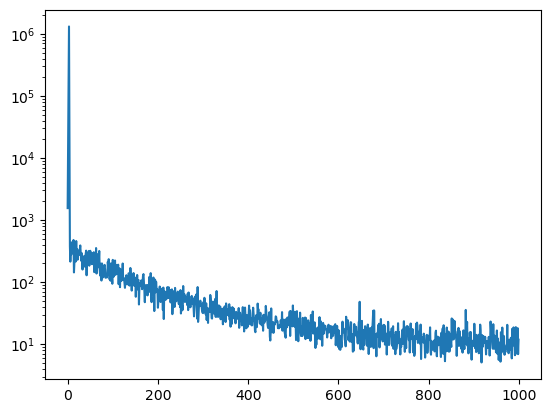

In [71]:
plt.semilogy(loss_iter)

In [72]:
test_data = input_data[700000:710000]
z_pred = predict(params,test_data)

(-1.0, 6.0)

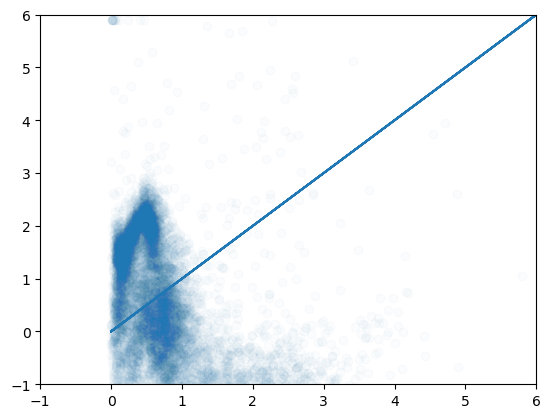

In [73]:
plt.scatter(spec_z[700000:710000],z_pred,alpha=0.02)
plt.plot(spec_z[700000:710000],spec_z[700000:710000])
plt.xlim(-1,6)
plt.ylim(-1,6)

Next we perform a magic: we only need to distribute the weights on different devices, then the computation is automatically sharded.

The only thing we need to think is how we shard the data on different devices. The core idea is, we must first figure out what we want. Take a simplest example, we have matrix `A = [[1,2],[3,4],[5,6],[7,8]]`, `B = [9,10]`. And we have CPU 0-CPU 8. Here we want to do $C = A\cdot B$. That is, our new matrix is `C = [[1*9,2*10],[3*9,4*10],[5*9,6*10],[7*9,8*10]]`.

If we want our eight cores compute eight element seperately, think about how we should put the data? We want CPU 0 to compute 1\*9, so we should send 1 and 9 to CPU0. Similarly, 2 and 10 to CPU 1, 3 and 9 to CPU 2...

Finally, we send each element of A to a distinct CPU, send 9 to CPU 0,2,4,6, send 10 to CPU 1,3,5,7.

In [81]:
sharding = sharding.reshape(4, 2)

w1 = jax.random.normal(jax.random.PRNGKey(0),[5,64])
b1 = jax.random.normal(jax.random.PRNGKey(1),[64])
w2 = jax.random.normal(jax.random.PRNGKey(2),[64,64])
b2 = jax.random.normal(jax.random.PRNGKey(3),[64])
w3 = jax.random.normal(jax.random.PRNGKey(8),[64,1])
w1 = jax.device_put(w1, sharding.replicate())
b1 = jax.device_put(b1, sharding.replicate())

w2 = jax.device_put(w2, sharding.replicate(0))
b2 = jax.device_put(b2, sharding.replicate(0))

w3 = jax.device_put(w3, sharding.replicate(0).T)

params = {'w1':w1,'w2':w2,'w3':w3,'b1':b1,'b2':b2}

In [82]:
%%time
loss_iter = []
iters = 1000
key = jax.random.PRNGKey(0)

batch = 2048

for i in range(iters):
    key, subkey = jax.random.split(key)
    idx = jax.random.randint(key,[batch],0,700000)
    inputs = (jax.device_put(input_data[idx], sharding.replicate(1)),jax.device_put(spec_z[idx], sharding.replicate()))
    loss_value,loss_grad_val = loss_grad(params,inputs)
    loss_iter.append(loss_value)
    params = gradient_descent(params,loss_grad_val)

CPU times: user 1min 38s, sys: 3.17 s, total: 1min 41s
Wall time: 6.35 s


In [83]:
jax.debug.visualize_array_sharding(params['w3'])
jax.debug.visualize_array_sharding(loss_grad_val['w3'])

           
           
CPU 0,2,4,6
           
           
           
           
           
CPU 1,3,5,7
           
           
           

           
           
CPU 0,2,4,6
           
           
           
           
           
CPU 1,3,5,7
           
           
           

In [84]:
%time loss_value,loss_grad_val = loss_grad(params,inputs)

CPU times: user 78.2 ms, sys: 2.17 ms, total: 80.4 ms
Wall time: 5.07 ms


### Example: Parallel convolution

OK, let's go back to the convolution problem when we were talk about. Some times we just cannot figure out how to distribute things to each device because that the operation is too complicated. In this case we can utilize the `shmap` function to help.

More reference can be found in [this url](https://jax.readthedocs.io/en/latest/jep/14273-shard-map.html).

In [47]:
#suppose here w is a 1d vector of length 3
@jax.jit
def convolve(x,w):
    y = jnp.concatenate([x,jnp.zeros([w.shape[0]-1])],axis = 0)
    for i in range(len(x)):
        x = x.at[i].set(jnp.sum(y[i:i+w.shape[0]]+w))
    return x

x = jax.random.uniform(jax.random.PRNGKey(0), [8096,1024])
w = jnp.arange(0,32)

In [70]:
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental import mesh_utils
from jax.experimental.shard_map import shard_map
from jax.sharding import NamedSharding
import numpy as np


devices = np.array(jax.devices())
m = Mesh(devices, ('i',))  # mesh.shape['i'] = 4

convolve_batch = jax.jit(jax.vmap(lambda x: convolve(x,w)))

In [66]:
x_shard = jax.device_put(x,NamedSharding(m,P('i')))
w_shard = jax.device_put(w,NamedSharding(m,P(None)))

convolve_shard = jax.vmap(lambda x: convolve(x,w_shard))

convolve_shard = jax.jit(shard_map(convolve_shard, m, in_specs=P('i'), out_specs=P('i')))

In [79]:
%time y = convolve_batch(x)

CPU times: user 347 ms, sys: 17 ms, total: 364 ms
Wall time: 278 ms


In [80]:
%time y_shard = convolve_shard(x_shard)

CPU times: user 195 ms, sys: 6.59 ms, total: 202 ms
Wall time: 4.45 ms


In [145]:
jax.debug.visualize_array_sharding(y_shard)

  CPU 0  
         
  CPU 1  
         
  CPU 2  
         
  CPU 3  
         
  CPU 4  
         
  CPU 5  
         
  CPU 6  
         
  CPU 7  
         

In [78]:
x = jax.random.uniform(jax.random.PRNGKey(10), [8096,1024])
x_shard = jax.device_put(x,NamedSharding(m,P('i')))

In [63]:
devices

array([CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3),
       CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)],
      dtype=object)